## Aggregated Pitch Control

Based on data from Metrica Sport, I wanted to see if I could create Pitch Control models for each of the goals that the Home team scores and then aggregate them onto the same pitch to see if a trend emerges.

In [1]:
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import Metrica_PitchControl as mpc
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import pandas as pd

DATADIR = r'C:\Users\paul9977\Documents\Projects\Soccer Analytics\Friends of Tracking\LaurieOnTracking\sample-data-master\data'
game_id=2

events = mio.read_event_data(DATADIR, game_id)

# read in tracking data
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True,filter_='moving_average')
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True,filter_='moving_average')

Reading team: home
Reading team: away


In [2]:
# Let's create a dataframe for the home team's goals
shots = events[events['Type']=='SHOT']
home_shots = shots[shots['Team']=='Home']
goals = home_shots[home_shots['Subtype'].str.contains('-GOAL')]
goals

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,-47.70,-3.40,-54.06,-2.04
1118,Home,SHOT,HEAD-ON TARGET-GOAL,2,73983,2959.32,73995,2959.80,Player9,NaN,-47.70,1.36,-54.06,2.04
1723,Home,SHOT,ON TARGET-GOAL,2,121027,4841.08,121055,4842.20,Player12,NaN,-30.74,5.44,-54.06,2.72


In [3]:
# Here we are creating a list of each goal's Pitch Control Model
total_PPCF = []
params = mpc.default_model_params(3)
cmap = 'bwr'
# We've taken frames 2 seconds before the ball goes in to see where the team is at right before scoring
for frame in goals['End Frame']-50:
    PPCF,xgrid,ygrid = mpc.generate_pitch_control_tracking(frame, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
    total_PPCF.append(PPCF)

In [4]:
#This aggregates the models into a single array, simply by adding them together
i = 0
for array in total_PPCF:
    if i == 0:
        final_array = array.copy()
        i+=1
    else:
        final_array += array
        i+=1

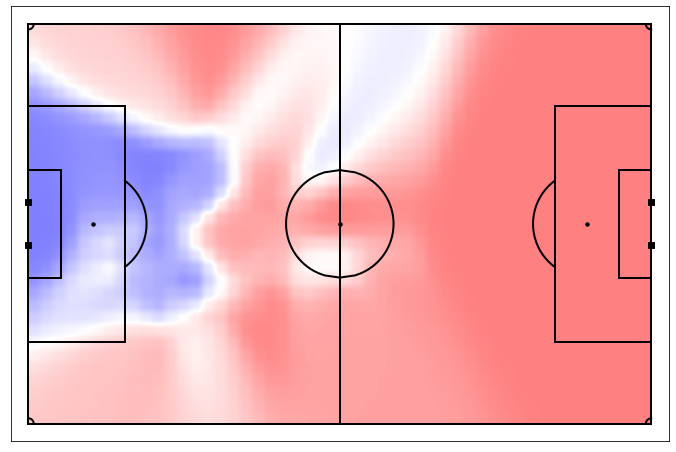

In [5]:
# And then we plot!
fig,ax = mviz.plot_pitch(field_color='white', field_dimen = (106, 68))
# Notice that for the normalizing factors we put vmax=len(goals) which will normalize all our models into one model [0:1]
ax.imshow(np.flipud(final_array), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),interpolation='hanning',vmin=0.0,vmax=len(goals),cmap=cmap,alpha=0.5)
plt.show()